In [144]:
import pandas as pd

df_income = pd.read_csv('../data/low_income_classification_by_year.csv')

df_income_subset = df_income[['zip_code', 'msa_name', 'year', 'income']]

df_college = pd.read_csv('../data/college_educated_classification_gentrified_overtime.csv')

df_college_subset = df_college[['zip_code', 'msa_name', 'year', 'per_college_educated']]

df_rent_2011 = pd.read_csv('../data/rent_2011.csv')

df_rent_2011 = df_rent_2011[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

df_rent_later = pd.read_csv('../data/rent_2012_2023.csv')

df_rent_later = df_rent_later[['zip_code', 'msa_name', 'year', 'median_contract_rent']]

df_rent = pd.concat([df_rent_later, df_rent_2011], ignore_index=True)

df_rent = df_rent.dropna(axis=1, how='any')

df = pd.merge(df_income_subset, df_college_subset, on=['zip_code', 'msa_name', 'year'], how='left')

df = pd.merge(df, df_rent, on=['zip_code', 'msa_name', 'year'], how='left')

df['zip_code'] = df['zip_code'].astype(str).str.zfill(5)

df = df.dropna()

df.to_csv('../data/train_data.csv')

In [145]:
df_start = df[df['year'] == 2012].copy()
df_end = df[df['year'] == 2022].copy()

df_start = df_start.rename(columns={
    'income': 'income_2012',
    'per_college_educated': 'college_2012',
    'median_contract_rent': 'rent_2012'
})

df_end = df_end.rename(columns={
    'income': 'income_2022',
    'per_college_educated': 'college_2022',
    'median_contract_rent': 'rent_2022'
})

df_merged = pd.merge(df_start, df_end, on=['zip_code', 'msa_name'], how='inner')

df_merged

,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0
...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0


In [146]:
df_merged['income_change'] = df_merged['income_2022'] - df_merged['income_2012']
df_merged['rent_change'] = df_merged['rent_2022'] - df_merged['rent_2012']
df_merged['college_change'] = df_merged['college_2022'] - df_merged['college_2012']

msa_medians = df_merged.groupby('msa_name')[['income_change', 'rent_change', 'college_change']].median().reset_index()
msa_medians = msa_medians.rename(columns={
    'income_change': 'msa_income_median',
    'rent_change': 'msa_rent_median',
    'college_change': 'msa_college_median'
})

df_final = pd.merge(df_merged, msa_medians, on='msa_name', how='left')

In [147]:
df_final['gentrified'] = (
    (df_final['income_change'] > df_final['msa_income_median']) &
    (df_final['rent_change'] > df_final['msa_rent_median']) &
    (df_final['college_change'] > df_final['msa_college_median'])
).astype(int)

df_final

,zip_code,msa_name,year_x,income_2012,college_2012,rent_2012,year_y,income_2022,college_2022,rent_2022,income_change,rent_change,college_change,msa_income_median,msa_rent_median,msa_college_median,gentrified
0,00602,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15106.0,20.1,2869.0,2022,20260.0,20.575270,3147.0,5154.0,278.0,0.475270,5673.0,314.0,3.181886,0
1,00603,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,15079.0,21.0,5897.0,2022,17703.0,22.823391,8366.0,2624.0,2469.0,1.823391,5673.0,314.0,3.181886,0
2,00610,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,16923.0,14.7,2055.0,2022,22796.0,21.915303,2389.0,5873.0,334.0,7.215303,5673.0,314.0,3.181886,1
3,00631,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,11651.0,14.7,272.0,2022,15658.0,28.327645,202.0,4007.0,-70.0,13.627645,5673.0,314.0,3.181886,0
4,00662,"Aguadilla-Isabela-San Sebastian, PR MSA",2012,14735.0,17.2,5257.0,2022,20283.0,24.169736,5551.0,5548.0,294.0,6.969736,5673.0,314.0,3.181886,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16353,99705,"Fairbanks, AK MSA",2012,80606.0,18.1,1955.0,2022,88788.0,23.022390,1742.0,8182.0,-213.0,4.922390,8789.5,-12.0,-1.967382,0
16354,99709,"Fairbanks, AK MSA",2012,72900.0,39.6,4365.0,2022,80467.0,40.215682,4455.0,7567.0,90.0,0.615682,8789.5,-12.0,-1.967382,0
16355,99712,"Fairbanks, AK MSA",2012,88716.0,34.3,818.0,2022,105787.0,31.573135,750.0,17071.0,-68.0,-2.726865,8789.5,-12.0,-1.967382,0
16356,99714,"Fairbanks, AK MSA",2012,69219.0,34.7,119.0,2022,66250.0,29.319955,45.0,-2969.0,-74.0,-5.380045,8789.5,-12.0,-1.967382,0


In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

test_df = df_final[df_final['msa_name'] == "Austin-Round Rock, TX MSA"]

X = test_df[['income_2012', 'rent_2012', 'college_2012']]
y = test_df['gentrified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
model = LogisticRegression(penalty='l2', C=0.1,class_weight='balanced',max_iter=1000)

pipeline = make_pipeline(scaler, model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])

In [149]:
wide_table = df.pivot(index=['zip_code', 'msa_name'], columns='year')

wide_table.columns = [f'{var}_{year}' for var, year in wide_table.columns]

wide_table = wide_table.dropna()

df_test = wide_table.loc[wide_table.index.get_level_values('msa_name') == "Austin-Round Rock, TX MSA"]

years = [2012, 2023]
income_change = df_test['income_2023'] - df_test['income_2012']
annual_growth_income = income_change / (2023 - 2012)

df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)

rent_change = df_test['median_contract_rent_2023'] - df_test['median_contract_rent_2012']
annual_growth_rent = rent_change / (2023 - 2012)

df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)

college_change = df_test['per_college_educated_2023'] - df_test['per_college_educated_2012']
annual_growth_college = college_change / (2023 - 2012)

df_test['college_2030'] = df_test['per_college_educated_2023'] + annual_growth_college * (2030 - 2023)

df_test

/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_5710/2993041363.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['income_2030'] = df_test['income_2023'] + annual_growth_income * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_5710/2993041363.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['rent_2030'] = df_test['median_contract_rent_2023'] + annual_growth_rent * (2030 - 2023)
/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_5710/29930413

,,income_2012,income_2013,income_2014,income_2015,income_2016,income_2017,income_2018,income_2019,income_2020,income_2021,...,median_contract_rent_2017,median_contract_rent_2018,median_contract_rent_2019,median_contract_rent_2020,median_contract_rent_2021,median_contract_rent_2022,median_contract_rent_2023,income_2030,rent_2030,college_2030
zip_code,msa_name,,,,,,,,,,,,,,,,,,,,,
76527,"Austin-Round Rock, TX MSA",44154.0,44977.0,47214.0,50625.0,51362.0,55333.0,57734.0,54940.0,65750.0,65245.0,...,397.0,385.0,338.0,387.0,536.0,393.0,410.0,108592.363636,436.727273,19.484729
76530,"Austin-Round Rock, TX MSA",55398.0,50463.0,52563.0,48333.0,44313.0,45223.0,47917.0,55938.0,57344.0,66563.0,...,192.0,197.0,145.0,143.0,184.0,147.0,95.0,131655.818182,67.636364,27.256073
76537,"Austin-Round Rock, TX MSA",56186.0,54479.0,53318.0,59826.0,60954.0,64730.0,68790.0,79773.0,79625.0,83401.0,...,389.0,445.0,375.0,390.0,654.0,726.0,836.0,121445.818182,1221.636364,28.463464
76574,"Austin-Round Rock, TX MSA",47585.0,45011.0,47854.0,43095.0,46125.0,50030.0,51613.0,54060.0,58631.0,62831.0,...,2239.0,2247.0,2034.0,1977.0,2068.0,2038.0,1949.0,88854.090909,1880.272727,21.029299
76578,"Austin-Round Rock, TX MSA",65040.0,57857.0,57589.0,62500.0,56094.0,63611.0,67976.0,70406.0,60833.0,76944.0,...,74.0,77.0,75.0,83.0,119.0,96.0,116.0,123065.454545,92.454545,23.391736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78757,"Austin-Round Rock, TX MSA",55156.0,57429.0,60856.0,61497.0,62992.0,65709.0,70489.0,76716.0,77560.0,87434.0,...,4737.0,4931.0,4925.0,4892.0,4488.0,4657.0,4274.0,136630.545455,4144.181818,75.858156
78758,"Austin-Round Rock, TX MSA",41792.0,43537.0,44476.0,43979.0,47244.0,50018.0,53547.0,55074.0,60769.0,63283.0,...,13854.0,14215.0,15021.0,15550.0,16702.0,17374.0,18101.0,86345.272727,21685.000000,54.290544
78759,"Austin-Round Rock, TX MSA",65672.0,66828.0,70095.0,71647.0,74379.0,76749.0,81066.0,85555.0,87080.0,90246.0,...,10883.0,11146.0,11099.0,11198.0,11463.0,11601.0,11981.0,126425.272727,12665.090909,67.095064


In [ ]:
X_future = df_test[['income_2030', 'rent_2030', 'college_2030']].dropna().copy()
X_future.columns = ['income_2012', 'rent_2012', 'college_2012']

X_future_scaled = scaler.transform(X_future)  # scale your future data

gentrification_probs_2035 = model.predict_proba(X_future_scaled)[:, 1]  # use scaled data here

df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035

df_test

[[-0.12251663  0.37777424  0.0807556 ]]


/var/folders/l5/c83q5w7j3wvcv1kvpg3d5qc80000gn/T/ipykernel_5710/950997595.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[X_future.index, 'gentrification_prob_2035'] = gentrification_probs_2035


,,income_2012,income_2013,income_2014,income_2015,income_2016,income_2017,income_2018,income_2019,income_2020,income_2021,...,median_contract_rent_2018,median_contract_rent_2019,median_contract_rent_2020,median_contract_rent_2021,median_contract_rent_2022,median_contract_rent_2023,income_2030,rent_2030,college_2030,gentrification_prob_2035
zip_code,msa_name,,,,,,,,,,,,,,,,,,,,,
76527,"Austin-Round Rock, TX MSA",44154.0,44977.0,47214.0,50625.0,51362.0,55333.0,57734.0,54940.0,65750.0,65245.0,...,385.0,338.0,387.0,536.0,393.0,410.0,108592.363636,436.727273,19.484729,0.340132
76530,"Austin-Round Rock, TX MSA",55398.0,50463.0,52563.0,48333.0,44313.0,45223.0,47917.0,55938.0,57344.0,66563.0,...,197.0,145.0,143.0,184.0,147.0,95.0,131655.818182,67.636364,27.256073,0.314310
76537,"Austin-Round Rock, TX MSA",56186.0,54479.0,53318.0,59826.0,60954.0,64730.0,68790.0,79773.0,79625.0,83401.0,...,445.0,375.0,390.0,654.0,726.0,836.0,121445.818182,1221.636364,28.463464,0.352024
76574,"Austin-Round Rock, TX MSA",47585.0,45011.0,47854.0,43095.0,46125.0,50030.0,51613.0,54060.0,58631.0,62831.0,...,2247.0,2034.0,1977.0,2068.0,2038.0,1949.0,88854.090909,1880.272727,21.029299,0.397239
76578,"Austin-Round Rock, TX MSA",65040.0,57857.0,57589.0,62500.0,56094.0,63611.0,67976.0,70406.0,60833.0,76944.0,...,77.0,75.0,83.0,119.0,96.0,116.0,123065.454545,92.454545,23.391736,0.320510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78757,"Austin-Round Rock, TX MSA",55156.0,57429.0,60856.0,61497.0,62992.0,65709.0,70489.0,76716.0,77560.0,87434.0,...,4931.0,4925.0,4892.0,4488.0,4657.0,4274.0,136630.545455,4144.181818,75.858156,0.448605
78758,"Austin-Round Rock, TX MSA",41792.0,43537.0,44476.0,43979.0,47244.0,50018.0,53547.0,55074.0,60769.0,63283.0,...,14215.0,15021.0,15550.0,16702.0,17374.0,18101.0,86345.272727,21685.000000,54.290544,0.848934
78759,"Austin-Round Rock, TX MSA",65672.0,66828.0,70095.0,71647.0,74379.0,76749.0,81066.0,85555.0,87080.0,90246.0,...,11146.0,11099.0,11198.0,11463.0,11601.0,11981.0,126425.272727,12665.090909,67.095064,0.661834


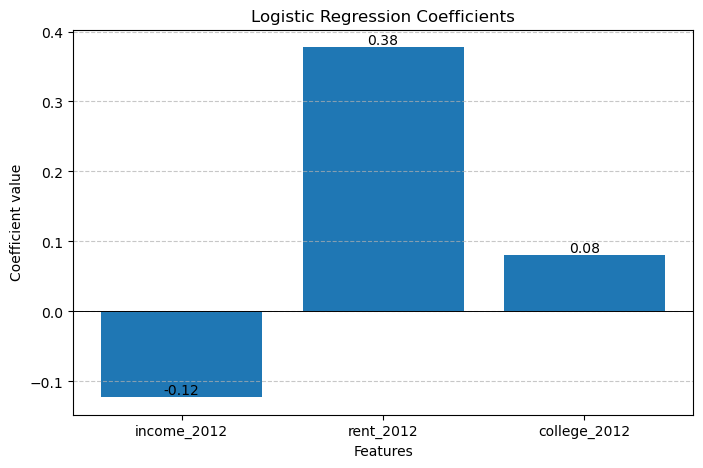

In [151]:
import matplotlib.pyplot as plt
import numpy as np

features = ['income_2012', 'rent_2012', 'college_2012']
coef = pipeline.named_steps['logisticregression'].coef_[0]

plt.figure(figsize=(8,5))
bars = plt.bar(features, coef)
plt.axhline(0, color='black', linewidth=0.7)
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient value')
plt.xlabel('Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

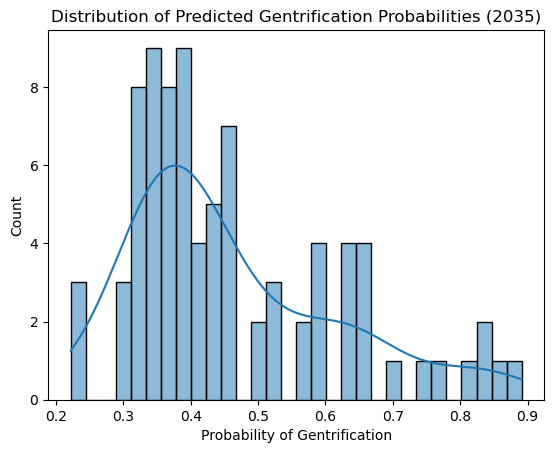

In [152]:
import seaborn as sns

sns.histplot(df_test['gentrification_prob_2035'], bins=30, kde=True)
plt.title('Distribution of Predicted Gentrification Probabilities (2035)')
plt.xlabel('Probability of Gentrification')
plt.ylabel('Count')
plt.show()

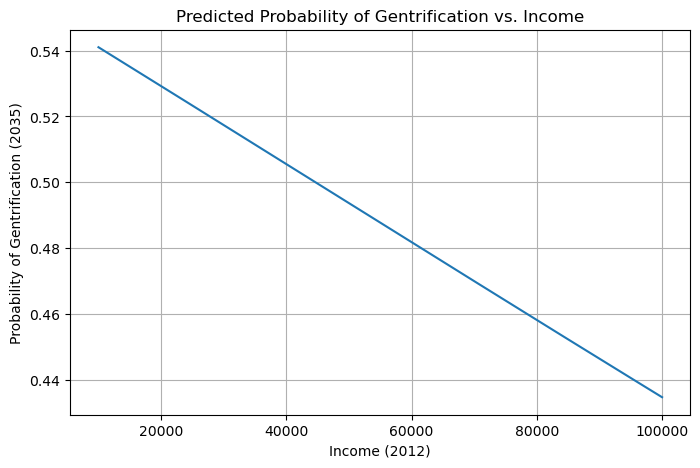

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Create a range of income values
income_range = np.linspace(10000, 100000, 500)

# Fix rent and college values at average levels
avg_rent = X_train['rent_2012'].mean()
avg_college = X_train['college_2012'].mean()

# Create input DataFrame
X_plot = pd.DataFrame({
    'income_2012': income_range,
    'rent_2012': avg_rent,
    'college_2012': avg_college
})

# Predict probabilities using the pipeline
probs = pipeline.predict_proba(X_plot)[:, 1]

# Plot
plt.figure(figsize=(8,5))
plt.plot(income_range, probs)
plt.title('Predicted Probability of Gentrification vs. Income')
plt.xlabel('Income (2012)')
plt.ylabel('Probability of Gentrification (2035)')
plt.grid(True)
plt.show()